In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from csv import reader
from sklearn.metrics import r2_score
from datetime import datetime
from datetime import timedelta as tdelta
from datetime import time as time

In [26]:
from Helper_funcs import *

## I. Data import ##

### I.a) Import positions ###

In [27]:
csv_file_name = 'sensor_positions.csv'
coords = []
IDs = []
dir_path = 'data/'

stations_df = import_sensor_positions(dir_path, csv_file_name)
stations_df.set_index('IDs', inplace=True)
IDs = list(stations_df.index)

del csv_file_name, coords

### I.b) Form groups based on distance between stations ###

In [28]:
groups = make_groups(IDs, stations_df)
stations_df.insert(loc=1, column='grps', value=groups['grp'])

del groups

create groups of sensors based on distance between them


### I.c) Import sound pressure values ###

In [29]:
dir_path = './PreviousAssignments/data'
csv_file_names = []

for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        if path.find('data.csv') != -1:
            csv_file_names.append(path)
            
del path, dir_path

Append all csv files to a list of dataframes and add the id of the sensor to distinguish them later on

In [30]:
list_df = []
IDs = []


for filename in csv_file_names:
    df = pd.read_csv('./PreviousAssignments/data/' + filename, index_col=None, header=0)
    df['Time'] = df.apply(lambda row: datetime.strptime(row['Time'], '%Y-%m-%d %H:%M:%S'), axis=1)
    IDs.append(filename[12:16]);
    list_df.append(df);

# list_len = [len(df) for df in list_df];

del filename, csv_file_names

### I.d) Get rid of duplicates and fill in missing timestamps ###
-> data is transformed into uniformely sampled data with `np.nan()` in place of missing values
-> start date is 2022.02.20 00:00:00, stop date is 2022.03.05 00:00:00
-> all data is organised into a DataFrame, columns=Sensor IDs, index=Timestamps

In [31]:
start_time = datetime.strptime('2022.02.20 00:00:00', '%Y.%m.%d %H:%M:%S')
end_time = datetime.strptime('2022.03.05 00:00:00', '%Y.%m.%d %H:%M:%S')
tindex = pd.date_range(start_time, end_time, freq='1min')
data_label='dt_sound_level_dB'

df_data_incomplete = pd.DataFrame(index=tindex, columns=IDs)

idx = 0
for df in list_df:
    # get rid of redundant datapoints
    df = df[df.Time >= start_time]
    df = df[df.Time <= end_time]
    df.drop_duplicates(subset='Time', keep='first', inplace=True)
    
    # index data by Time
    df.index = pd.to_datetime(df['Time'])
    df.drop(columns=['Time'], inplace=True)
    df = df.reindex(tindex)
    
    df_data_incomplete[IDs[idx]] = df[data_label]
    idx = idx + 1
    
#print(df_data_incomplete.isna().sum())

del df, idx, list_df, data_label

## II. Interpolation ##

### II.a) Simple interpolation ###
-> 'nearest'

-> 'linear'

In [32]:
#interpolate data using 'nearest' method

#temp_df = df_data_incomplete.interpolate(method='nearest')
#df_data_nearest = temp_df.interpolate(limit_area=None, method='backfill')
  
#temp_df = df_data_incomplete.interpolate(method='linear')
#df_data_linear = temp_df.interpolate(limit_area=None, method='backfill') 
#df_data_linear.apply(lambda x: np.round(x, 1), 1);


### II.b) Attempts on advanced interpolation ###

#### II.b.1) Raw data separation and filtering ####
-> data is separated into 2 groups: workdays(`df_work_...`), weekenddays(`df_end_...`)

-> average workday (`df_workd_mean`) and average weekend day (`df_endd_mean`) are created by averaging all available data for a specific timestamp of all workdays/weekend days

In [33]:
day_str = datetime.strptime('2023.05.01 00:00:00', '%Y.%m.%d %H:%M:%S')
day_stp = datetime.strptime('2023.05.01 23:59:59', '%Y.%m.%d %H:%M:%S')
daindex = pd.date_range(day_str, day_stp, freq='1min')

df_workd_mean = pd.DataFrame(index=daindex, columns=IDs)
df_endd_mean = pd.DataFrame(index=daindex, columns=IDs)

df_work_all = df_data_incomplete.loc[df_data_incomplete.index.day_of_week < 5].copy()
df_end_all = df_data_incomplete.loc[df_data_incomplete.index.day_of_week > 4].copy()

for moment in daindex:
    idxs_work = df_work_all.index.indexer_at_time(moment.time())
    idxs_end = df_end_all.index.indexer_at_time(moment.time())
    # df_workd_mean - average workday of the station
    df_workd_mean.loc[moment] = df_work_all.iloc[idxs_work].mean()
    # df_endd_mean - average weekend day of the station
    df_endd_mean.loc[moment] = df_end_all.iloc[idxs_end].mean()

del day_stp, day_str, idxs_work, idxs_end, moment

#### II.b.4) Mean-day model interpolation ####
-> mean work and weekend day are expanded into whole available time period for simpler computations

In [34]:

df_mean_ww = df_work_all.copy()
df_mean_we = df_end_all.copy()

for moment in daindex:
    idxs_work = df_work_all.index.indexer_at_time(moment.time())
    idxs_end = df_end_all.index.indexer_at_time(moment.time())
    
    df_mean_ww.iloc[idxs_work] = df_workd_mean.loc[moment]
    df_mean_we.iloc[idxs_end] = df_endd_mean.loc[moment]
    
df_mean = pd.concat([df_mean_we, df_mean_ww], axis=0)
df_mean.sort_index(inplace=True)

del df_mean_ww, df_mean_we, idxs_end, idxs_work, moment, df_work_all, df_end_all

print(df_mean.isna().sum())

2004    1569
2018    1740
201D    1906
2024    1678
206D    2154
2071    1622
2078    2086
2095    1493
20A6    1961
2148    1712
230F    1954
2349    2006
dtype: int64


#### II.b.3) Neighbor data interpolation ####
Missing data is filled with data of neighboring sensors
1) calculate correlation coefficients
    1) for raw data
    2) for average day
2) calculate linear approximation (no offset)
3) approximate missing data (only if raw data available)

In [35]:
# 1.1)
IDs_set = set(IDs);

tdata = [[] for _ in range(len(stations_df))]
stations_df['grp_corrs_i']= tdata
icors = []
ixx = []
iscorr = []

for id in IDs:
    # 1) extract group of sensors
    if id in stations_df.index:
        group = set(stations_df.loc[id]['grps'])
        # 2) filter out non-existing sensors
        group = list(IDs_set & group)
        # 3) extract data
        group_df = df_data_incomplete[group]
        single_df = df_data_incomplete[id]
        stations_df['grps'][id] = group
        corrs = []
        icors = []
        for fid in group:
            # 5) determine lag for precision improvement
            tempc = calculate_correlations(single_df, group_df[fid])
            ttemp = list(np.absolute(tempc))
            itemp = ttemp.index(max(ttemp))
            ttuple = (tempc[itemp], itemp-10, fid)
            corrs.append(ttuple)
            icors.append(max(tempc))
            
        stations_df['grp_corrs_i'][id] = corrs
        ixx.append(id)
        iscorr.append(icors)
        #print(corrs)

del tempc, ttemp, itemp, ttuple, icors, group, corrs


C:\Users\radek\AppData\Local\Temp\ipykernel_1748\20821138.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_df['grps'][id] = group
C:\Users\radek\AppData\Local\Temp\ipykernel_1748\20821138.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_df['grp_corrs_i'][id] = corrs
C:\Users\radek\AppData\Local\Temp\ipykernel_1748\20821138.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_df['grps'][id] = group
C:\

In [36]:
# 1.2)
IDs_set = set(IDs);

tdata = [[] for _ in range(len(stations_df))]
stations_df['grp_corrs_m']= tdata

mcors = []
mxx = []

mscors = []
msxx = []

for id in IDs:
    # 1) extract group of sensors
    if id in stations_df.index:
        group = set(stations_df.loc[id]['grps'])
        # 2) filter out non-existing sensors
        group = list(IDs_set & group)
        # 3) extract data
        group_df = df_mean[group]
        single_df = df_mean[id]
        stations_df['grps'][id] = group
        corrs = []
        mcors = []
        for fid in group:
            # 5) determine lag for precision improvement
            temp = calculate_correlations(single_df, group_df[fid])
            ttemp = list(np.absolute(temp))
            itemp = ttemp.index(max(ttemp))
            ttuple = (temp[itemp], itemp-10, fid)
            mcors.append(max(temp))
            corrs.append(ttuple)
        stations_df['grp_corrs_m'][id] = corrs
        mxx.append(id)
        mscors.append(mcors)
        #print(corrs)

del temp, ttemp, itemp, ttuple, mcors, group, corrs

C:\Users\radek\AppData\Local\Temp\ipykernel_1748\2284793224.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_df['grps'][id] = group
C:\Users\radek\AppData\Local\Temp\ipykernel_1748\2284793224.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_df['grp_corrs_m'][id] = corrs
C:\Users\radek\AppData\Local\Temp\ipykernel_1748\2284793224.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_df['grps'][id] = gro

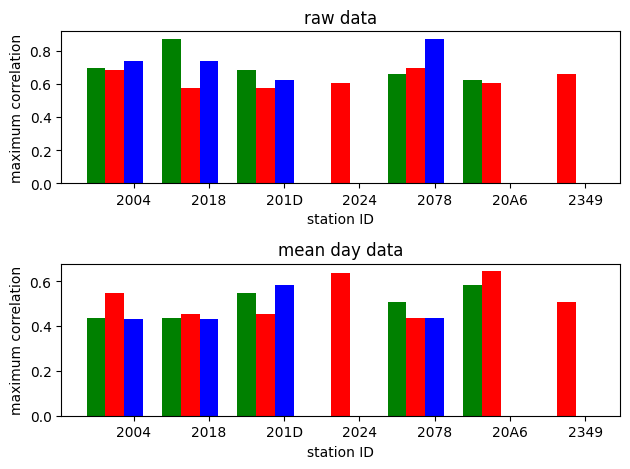

In [37]:
fig, ax = plt.subplots(2,1)

arr0 = []
arr1 = []
arr2 = []
for i in range(0,len(iscorr)):
    arr0.append(iscorr[i][0])
    if len(iscorr[i]) > 1:
        arr1.append(iscorr[i][1])
    else:
        arr1.append(0)
        
    if len(iscorr[i]) > 2:
        arr2.append(iscorr[i][2])
    else:
        arr2.append(0)
        
X = np.arange(len(ixx))

ax[0].set_xlabel('station ID')
ax[0].set_ylabel('maximum correlation')
ax[0].bar(X, arr0, color='r', width = 0.25)
ax[0].bar(X-.25, arr1, color='g', width = 0.25)
ax[0].bar(X+.25, arr2, color='b', width = 0.25, tick_label=ixx)
ax[0].set_title('raw data')

arr0 = []
arr1 = []
arr2 = []
for i in range(0,len(mscors)):
    arr0.append(mscors[i][0])
    if len(mscors[i]) > 1:
        arr1.append(mscors[i][1])
    else:
        arr1.append(0)
        
    if len(mscors[i]) > 2:
        arr2.append(mscors[i][2])
    else:
        arr2.append(0)
        
X = np.arange(len(mxx))

ax[1].set_xlabel('station ID')
ax[1].set_ylabel('maximum correlation')
ax[1].bar(X, arr0, color='r', width = 0.25, tick_label=mxx)
ax[1].bar(X - .25, arr1, color='g', width = 0.25, tick_label=mxx)
ax[1].bar(X + .25, arr2, color='b', width = 0.25, tick_label=mxx)
ax[1].set_title('mean day data')

fig.tight_layout()
plt.show()

del X, arr0, arr1, arr2, iscorr, ixx, mxx, mscors

Raw data clearly shows higher correlation than the averaged one - raw data will be used to fill missing values.

In [38]:
# 2) calculate betas and alphas
   
xx = []
betas = []    
    
IDs_set = set(IDs);

tdata = [[] for _ in range(len(stations_df))]
stations_df['grp_linear']= tdata

for id in IDs:
    if id in stations_df.index:
        group_ls = stations_df.loc[id]['grp_corrs_i']
        single_df = df_data_incomplete[id]
        beta = []
        for ftup in group_ls:
            # 5) determine lag for precision improvement
            fid = ftup[2]
            lag = ftup[1]
            group_df = df_data_incomplete[fid]
            tbe, tal = calculate_linear_regression(single_df, group_df, lag)
            ttuple = (tbe, tal, lag, fid)
            beta.append(ttuple)
            
        stations_df['grp_linear'][id] = beta
        xx.append(id)
        betas.append(beta)
        
del tbe, tal, ttuple, ftup, fid, lag, xx, beta, betas

C:\Users\radek\AppData\Local\Temp\ipykernel_1748\1727399909.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_df['grp_linear'][id] = beta
C:\Users\radek\AppData\Local\Temp\ipykernel_1748\1727399909.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_df['grp_linear'][id] = beta
C:\Users\radek\AppData\Local\Temp\ipykernel_1748\1727399909.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_df['grp_linear'][

In [39]:
df_data_neighbor = df_data_incomplete.copy()
group_df = pd.DataFrame()
rmses = []
xx = []

# 3) Fill in missing values
for id in IDs:
    if id in stations_df.index:
        group_ls = stations_df.loc[id]['grp_linear']
        single_df = df_data_incomplete[id].copy()
        betas = []
        alphas = []
        lags = []
        group_df.drop(columns = group_df.columns, inplace=True)
        for ftup in group_ls:
            # 5) determine lag for precision improvement
            beta = ftup[0]
            alpha = ftup[1]
            lag = ftup[2]
            betas.append(beta)
            alphas.append(alpha)
            lags.append(lag)
            group_df[ftup[3]] = df_data_incomplete[ftup[3]]
        
        df_neighbor_temp, rmset = fill_missing_values(single_df, group_df, lags, betas, alphas)  
        df_data_neighbor[id] = df_neighbor_temp
        rmses.append(rmset)
        xx.append(id)

print(df_data_incomplete.isna().sum())
print(df_data_neighbor.isna().sum())

2004    12766
2018    13101
201D    13245
2024    12785
206D    13632
2071    13088
2078    13020
2095    12734
20A6    13883
2148    12464
230F    13555
2349    12658
dtype: int64
2004     6563
2018     6546
201D     7330
2024     9901
206D    13632
2071    13088
2078     6131
2095    12734
20A6     8196
2148    12464
230F    13555
2349     9267
dtype: int64


The values acquired by linear combination of all group stations are compared with original data of main station where possible. Used metric is RMSE

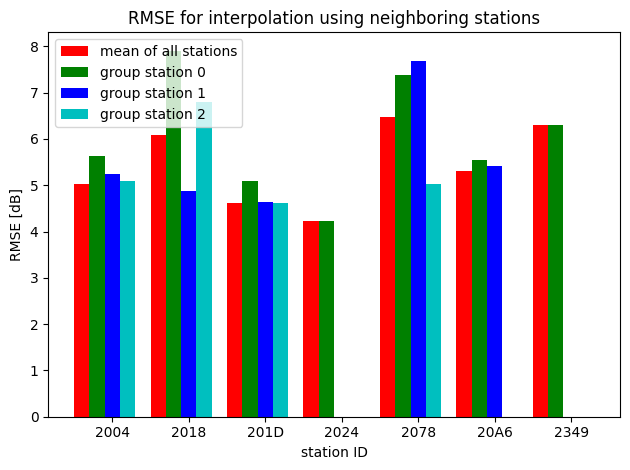

In [40]:
fig, ax = plt.subplots(1,1) 

arr0 = []
arr1 = []
arr2 = []
arr3 = []
for i in range(0,len(rmses)):
    arr0.append(rmses[i][0])
    if len(rmses[i]) > 1:
        arr1.append(rmses[i][1])
    else:
        arr1.append(0)
        
    if len(rmses[i]) > 2:
        arr2.append(rmses[i][2])
    else:
        arr2.append(0) 
    if len(rmses[i]) > 3:
        arr3.append(rmses[i][3])
    else:
        arr3.append(0) 
        
X = np.arange(len(xx))

ax.set_xlabel('station ID')
ax.set_ylabel('RMSE [dB]')
ax.bar(X-.30, arr0, color='r', width = 0.20)
ax.bar(X-.10, arr1, color='g', width = 0.20)
ax.bar(X+.10, arr2, color='b', width = 0.20, tick_label=xx)
ax.bar(X+.30, arr3, color='c', width = 0.20)
ax.set_title('RMSE for interpolation using neighboring stations')
ax.legend(['mean of all stations', 'group station 0',
           'group station 1', 'group station 2'])


fig.tight_layout()
plt.show()
        
del xx, rmset, X, arr1, arr2, arr3, arr0

Since the combination of all members of the group does not always give best results, Kalman fiter assimilation approach is applied where RMSE is used as variance aproximation


In [41]:
df_data_neighbor = df_data_incomplete.copy()
group_df = pd.DataFrame()
rmses1 = []
xx = []

# 3) Fill in missing values
for id in IDs:
    if id in stations_df.index:
        group_ls = stations_df.loc[id]['grp_linear']
        single_df = df_data_incomplete[id].copy()
        betas = []
        alphas = []
        lags = []
        group_df.drop(columns = group_df.columns, inplace=True)
        for ftup in group_ls:
            # 5) determine lag for precision improvement
            beta = ftup[0]
            alpha = ftup[1]
            lag = ftup[2]
            betas.append(beta)
            alphas.append(alpha)
            lags.append(lag)
            group_df[ftup[3]] = df_data_incomplete[ftup[3]]
        
        df_neighbor_temp, rmset = fill_missing_values_assim(single_df, group_df, lags, betas, alphas)  
        df_data_neighbor[id] = df_neighbor_temp
        rmses1.append(rmset)
        xx.append(id)
        
del beta, alpha, lag, betas, alphas, lags
#print(df_data_incomplete.isna().sum())
#print(df_data_neighbor.isna().sum())

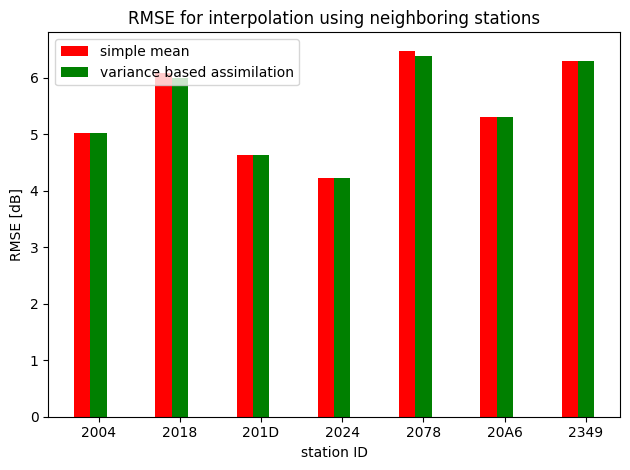

In [42]:
fig, ax = plt.subplots(1,1) 

arr0 = []
arr1 = []
for i in range(0,len(rmses)):
    arr0.append(rmses[i][0])

for i in range(0,len(rmses1)):
    arr1.append(rmses1[i][-1])
        
X = np.arange(len(xx))

ax.set_xlabel('station ID')
ax.set_ylabel('RMSE [dB]')
ax.bar(X-.10, arr0, color='r', width = 0.20)
ax.bar(X+.10, arr1, color='g', width = 0.20, tick_label=xx)
ax.set_title('RMSE for interpolation using neighboring stations')
ax.legend(['simple mean', 'variance based assimilation'])


fig.tight_layout()
plt.show()

del rmses, rmses1, msxx, rmset, X, xx, ftup

Since using assimilation gives less errneous results, it will also be used to fill possible data gaps in mean day models

In [43]:
# 4) Fill in missing values for mean day and weekend
# 4.1) mean weekend
rmses = []
rmses1 = []
xx = []
df_endd_mean_n = df_endd_mean.copy()
for id in IDs:
    if id in stations_df.index:
        group_ls = stations_df.loc[id]['grp_linear']
        single_df = df_endd_mean[id].copy()
        betas = []
        alphas = []
        lags = []
        group_df.drop(columns = group_df.columns, inplace=True)
        for ftup in group_ls:
            # 5) determine lag for precision improvement
            beta = ftup[0]
            alpha = ftup[1]
            lag = ftup[2]
            betas.append(beta)
            alphas.append(alpha)
            lags.append(lag)
            group_df[ftup[3]] = df_endd_mean[ftup[3]]
        
        df_neighbor_temp, rmset = fill_missing_values_assim(single_df, group_df, lags, betas, alphas)  
        df_endd_mean_n[id] = df_neighbor_temp
        rmses.append(rmset)
        xx.append(id)
        
#temp_df = df_endd_mean_n.interpolate(method='nearest')
#df_endd_mean_ne = temp_df.interpolate(limit_area=None, method='backfill')
        
del beta, alpha, lag, betas, alphas, lags, df_endd_mean
#print(df_endd_mean.isna().sum())

df_workd_mean_n = df_workd_mean.copy()
for id in IDs:
    if id in stations_df.index:
        group_ls = stations_df.loc[id]['grp_linear']
        single_df = df_workd_mean[id].copy()
        betas = []
        alphas = []
        lags = []
        group_df.drop(columns = group_df.columns, inplace=True)
        for ftup in group_ls:
            # 5) determine lag for precision improvement
            beta = ftup[0]
            alpha = ftup[1]
            lag = ftup[2]
            betas.append(beta)
            alphas.append(alpha)
            lags.append(lag)
            group_df[ftup[3]] = df_workd_mean[ftup[3]]
        
        df_neighbor_temp, rmset = fill_missing_values_assim(single_df, group_df, lags, betas, alphas)  
        df_workd_mean_n[id] = df_neighbor_temp
        rmses1.append(rmset)
        
del beta, alpha, lag, betas, alphas, lags, df_workd_mean, df_neighbor_temp

#print(df_workd_mean.isna().sum())
#print(df_workd_mean_n.isna().sum())

#### II.b.4) Mean-day model interpolation ####
-> mean work and weekend day are expanded into whole available time period for simpler computations

In [44]:
df_mean_ww = df_data_incomplete.loc[df_data_incomplete.index.day_of_week < 5].copy()
df_mean_we = df_data_incomplete.loc[df_data_incomplete.index.day_of_week > 4].copy()

for moment in daindex:
    idxs_work = df_mean_ww.index.indexer_at_time(moment.time())
    idxs_end = df_mean_we.index.indexer_at_time(moment.time())
    
    df_mean_ww.iloc[idxs_work] = df_workd_mean_n.loc[moment]
    df_mean_we.iloc[idxs_end] = df_endd_mean_n.loc[moment]
    
df_mean = pd.concat([df_mean_we, df_mean_ww], axis=0)
df_mean.sort_index(inplace=True)

del df_mean_ww, df_mean_we, idxs_end, idxs_work, moment

#### II.b.4) Determine resampling period ####

Determine resampling period based on rmse=f(Tresample)

1) for mean interpolation
2) for linear interpolation

The data is downsampled for sampling periods of [1, 2, 5, 10, 15, 20, 30, 60] minutes and rmse is calculated to provide an esimate for information loss

1) no interpolation - simple resampling

9360
9360


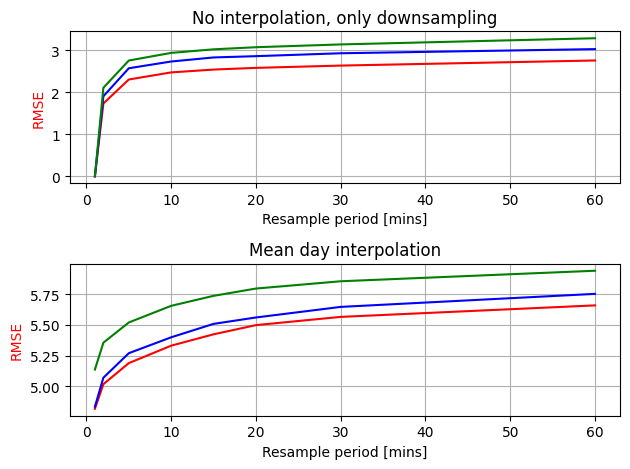

In [45]:
list_rmses = []
resample_pers = [1, 2, 5, 10, 15, 20, 30, 60]
fig, ax = plt.subplots(2,1)


no_interpolation_res = evaluate_resample(df_data_incomplete, df_data_incomplete) 

list_rmses.append(list(no_interpolation_res[0].mean()))
list_rmses.append(list(no_interpolation_res[1].mean()))
list_rmses.append(list(no_interpolation_res[2].mean()))

ax[0] = init_ax_resamp(ax[0], resample_pers, list_rmses)
ax[0].set_title('No interpolation, only downsampling')  

mean_interpolation_res = evaluate_resample(df_data_incomplete, df_mean)
 
list_rmses = []
list_rmses.append(list(mean_interpolation_res[0].mean()))
list_rmses.append(list(mean_interpolation_res[1].mean()))
list_rmses.append(list(mean_interpolation_res[2].mean()))

ax[1] = init_ax_resamp(ax[1], resample_pers, list_rmses)
ax[1].set_title('Mean day interpolation')

fig.tight_layout()
plt.show()

1) mean interpolation - average days

Although simple downsampling shows lower error, it cannot be used, due to missing values. The average day uses larger datasets for computation, which reduces probability of missing datapoints and also offers simple way of updating the model, since each value is basically an average of all values within given time period.

Period of 10mins was chosen due to reasonable precision (compared to other resample periods) and considerable memory savings.

In [51]:
df_mean = df_mean.resample('10T').mean()
df_mean = df_mean.resample('1T').ffill()
df_complete_temp = pd.DataFrame()
df_data_complete = df_data_incomplete.copy()
rmset = []
rmses = []

for id in IDs:
    if id in stations_df.index:
        group_ls = stations_df.loc[id]['grp_linear']
        single_df = df_data_incomplete[id].copy()
        betas = []
        alphas = []
        lags = []
        group_df.drop(columns = group_df.columns, inplace=True)
        for ftup in group_ls:
            # 5) determine lag for precision improvement
            beta = ftup[0]
            alpha = ftup[1]
            lag = ftup[2]
            betas.append(beta)
            alphas.append(alpha)
            lags.append(lag)
            group_df[ftup[3]] = df_data_incomplete[ftup[3]]
            
        betas.append(1)
        alphas.append(0)
        lags.append(0)
        group_df['mean'] = df_mean[id]
        
        df_complete_temp, rmset = fill_missing_values_assim(single_df, group_df, lags, betas, alphas)  
        df_data_complete[id] = df_complete_temp
        rmses.append(rmset)
        xx.append(id)


In [49]:
df_mean = df_mean.resample('10T').mean()
df_mean = df_mean.resample('1T').ffill()
df_complete_temp = pd.DataFrame()
df_data_complete = df_data_incomplete.copy()
rmset = []
rmsel = []
xx = []

for id in IDs:
    if id in stations_df.index:
        group_ls = stations_df.loc[id]['grp_linear']
        single_df = df_data_incomplete[id].copy()
        betas = []
        alphas = []
        lags = []
        group_df.drop(columns = group_df.columns, inplace=True)
        for ftup in group_ls:
            # 5) determine lag for precision improvement
            beta = ftup[0]
            alpha = ftup[1]
            lag = ftup[2]
            betas.append(beta)
            alphas.append(alpha)
            lags.append(lag)
            group_df[ftup[3]] = df_data_incomplete[ftup[3]]
            
        betas.append(1)
        alphas.append(0)
        lags.append(0)
        group_df['mean'] = df_mean[id]
        
        df_complete_temp, rmset = fill_missing_values(single_df, group_df, lags, betas, alphas)  
        df_data_complete[id] = df_complete_temp
        rmsel.append(rmset)
        xx.append(id)


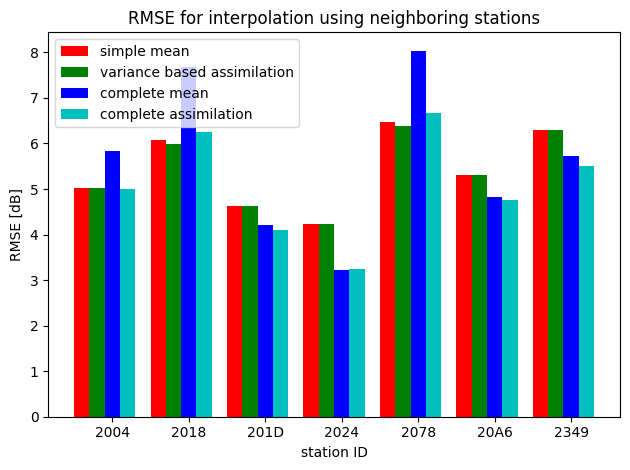

In [52]:
fig, ax = plt.subplots(1,1) 

arr3 = []

for i in range(0,len(rmses)):
    arr3.append(rmses[i][-1])
    
arr2 = []

for i in range(0,len(rmsel)):
    arr2.append(rmsel[i][-1])

xx = xx[0:7]
X = np.arange(len(xx))

ax.set_xlabel('station ID')
ax.set_ylabel('RMSE [dB]')
ax.set_xlabel('station ID')
ax.set_ylabel('RMSE [dB]')
ax.bar(X-.30, arr0, color='r', width = 0.20)
ax.bar(X-.10, arr1, color='g', width = 0.20)
ax.bar(X+.10, arr2, color='b', width = 0.20, tick_label=xx)
ax.bar(X+.30, arr3, color='c', width = 0.20)

ax.legend(['mean of all stations', 'group station 0',
           'group station 1', 'group station 2'])

ax.set_title('RMSE for interpolation using neighboring stations')
ax.legend(['simple mean', 'variance based assimilation', 'complete mean', 'complete assimilation'])


fig.tight_layout()
plt.show()

#del rmses, rmses1, msxx, rmset, X, xx, ftup

# TESTING #

In [ ]:
print(df_endd_mean.isna().sum())

In [53]:
print(np.mean(arr0))
print(np.mean(arr1))
print(np.mean(arr2))
print(np.mean(arr3))

5.433518610751507
5.405921476738393
5.644344612717336
5.075577165372644


In [ ]:
print(df_data_neighbor.isna().sum())

In [ ]:
def apply_assimilation(row, vars):
    if row.isna().sum() == len(row):
        return np.nan
    rmt= vars[row.notna()]
    rmt1 = np.zeros([len(rmt)])
    idxs = np.arange(len(rmt))
    for i in idxs:
        rmt1[i] = np.prod(rmt[idxs != i])

    k_kal = (rmt1) / sum(rmt1)
        
    row = row.dropna()
    row = row * k_kal
    
    #2 ) return assimilated data
    return row.sum()

def fill_missing_values_assim1(df_data1, df_data2, lags, betas, alphas):
    idx = 0
    rmsev = np.zeros(len(alphas))
    #) calculate linear regression + rmse for each member separately
    for label in df_data2.columns:
        df_data2[label] = df_data2[label].shift(periods=lags[idx]) * betas[idx] + alphas[idx]
        
        df_err = (df_data2[label] - df_data1)**2
        rmsev[idx] = np.sqrt(df_err.mean())
        
        idx = idx + 1
    #) use rmse as approximation of variation for kalman coefficients  
    df_fill = df_data2.apply(lambda row: apply_assimilation(row, rmsev), axis=1)
    
    indexer = (df_data1.isna()) & (df_fill.notna())
    
    #) get rmse for reference
    df_err = (df_fill - df_data1)**2    

    rmsevv          = np.zeros(len(rmsev) + 1)
    rmsevv[-1]      = (np.sqrt(df_err.mean()))

    idx = 0
    for idx in range(0, len(rmsev)):
        rmsevv[idx]    = rmsev[idx]

    
    df_data1[indexer] = df_fill[indexer]
    
    return df_data1.copy(), rmsev

group_df = pd.DataFrame()

df_neighbor_temp = pd.DataFrame()
id = IDs[0]
group_ls = stations_df.loc[id]['grps']
group_df[group_ls] = df_data_incomplete[group_ls]
single_df = df_data_incomplete[id].copy()
betas = [0.627250, 0.556386, 0.859106]
alphas = [18.43014, 22.01305, 8.072565]
lags = [5, 1, 0]

df_neighbor_temp, rmset = fill_missing_values_assim1(single_df, group_df, lags, betas, alphas) 

In [ ]:
def apply_assimilation(row, vars):
    rmt= vars[row.notna()]
    rmt1 = np.zeros([len(rmt)])
    idxs = np.arange(len(rmt))
    for i in idxs:
        rmt1[i] = np.prod(rmt[idxs != i])

    k_kal = (rmt1) / sum(rmt1)

    row = row.dropna()
    row = row * k_kal
    
    #2 ) return assimilated data
    return row.sum()
ll = np.array(group_df.iloc[5])
coefs = np.array([.1, .3, .5])
apply_assimilation(ll, coefs)

In [ ]:
ll =(group_df.iloc[5])
ll.isna().sum()

In [ ]:
ll = np.zeros(4)
dd = np.ones(2)

ll[0:-2] = dd
print(ll)